<a href="https://colab.research.google.com/github/isaaccorley/CS-6463-Trust-in-AI/blob/main/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS6463 Final
Implementation of "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", Simonyan et al. (2014)

In [1]:
!nvidia-smi

Sun May  8 19:27:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!wget !wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-05-08 19:33:11--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2022-05-08 19:33:11--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.75.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.75.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2022-05-08 19:33:11 (604 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

FINISHED --2022-05-08 19:33:11--
Total wall clock time: 0.4s
Downloaded: 1 files, 35K in 0.06s (604 KB/s)


In [ ]:
!pip install timm tqdm pillow numpy requests captum

In [137]:
import io
import json

import requests
import timm
import torch
import numpy as np
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet18
from tqdm import tqdm
from captum.attr import visualization

device = "cuda" if torch.cuda.is_available() else "cpu"

In [127]:
# Load imagenet class mapping
with open("imagenet_class_index.json") as f:
    idx2cls = json.load(f)
    idx2cls = {int(k): v[-1] for k, v in idx2cls.items()}
    cls2idx = {v: k for k, v in idx2cls.items()}

# Load and freeze pretrained imagenet model
model = timm.create_model("resnet18", pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model = model.eval()

# Load transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
mean = np.array(IMAGENET_MEAN)[None, :, None, None]
std = np.array(IMAGENET_STD)[None, :, None, None]

transforms = T.Compose([                 
		T.Resize(256),
		T.CenterCrop(224),
		T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

### Implementation of Section 2. Class Model Visualization

Given a zero image I and a pretrained frozen model F, maximize the output score of a given class y = F(I) w.r.t I. This is performed by optimizing L2 loss between F(I) and the desired output where the image are the trained parameters. The resulting image is then visualized below. 

In [112]:
def score_cam(model, cls: int = 0, num_steps: int = 10000, lr: float = 1E-1):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  
  model = model.to(device)
  mean = torch.tensor([0.485, 0.456, 0.406], requires_grad=False, device=device)[None, :, None, None]
  std = torch.tensor([0.229, 0.224, 0.225], requires_grad=False, device=device)[None, :, None, None]

  # Initialize zero image
  x = torch.nn.Parameter(torch.zeros(1, 3, 224, 224, requires_grad=True, device=device))

  # Initialize target
  y = torch.zeros((1, 1000), device=device)
  y[:, cls] = 1.0

  # Initialize optimizer and loss fn
  optim = torch.optim.SGD([x], lr=lr)
  mse = torch.nn.MSELoss()

  # Maximize class score w.r.t input image
  pbar = tqdm(range(num_steps))
  for _ in pbar:
    y_hat = model((x - mean) / std)
    loss = mse(y_hat, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_description(f"Loss: {float(loss)}")
  
  x = (x.detach() * std) + mean
  return x.cpu()

Loss: 0.0029417816549539566: 100%|██████████| 10000/10000 [01:40<00:00, 99.79it/s]


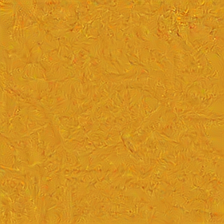

In [114]:
attr = score_cam(model=model, cls=cls2idx["dumbbell"], num_steps=10000)
attr = attr.clip(min=0, max=1)
attr = (attr - attr.min()) / (attr.max() - attr.min())
attr *= 255
attr = attr.to(torch.uint8)
attr = attr.squeeze(dim=0)
attr = attr.permute(1, 2, 0)
Image.fromarray(attr.numpy())

### Implementation of Section 3. Image-Specific Class Saliency Visualisation

By feeding and image through a model and taking the gradients w.r.t the predicted class and overlaying on the image we can visualize attributions for each pixel.


In [159]:
def download_image(url):
    r = requests.get(url)
    image = Image.open(io.BytesIO(r.content))
    return image

def visualize(attr, image):
    return visualization.visualize_image_attr(
        attr,
        np.array(image.resize((224, 224))),
        method="blended_heat_map",
        sign="absolute_value",
        show_colorbar=True
    ) 

def get_attr(url, model, transforms):
  image = download_image(url)
  x = transforms(image)
  x = x.reshape(1, 3, 224, 224)
  x = x.to(device)
  x.requires_grad = True
  y_hat = model(x)
  output_idx = y_hat.argmax()
  output_max = y_hat[0, output_idx]
  output_max.backward()
  attr = x.grad.data.squeeze(dim=0).abs()
  attr = attr.detach().cpu().numpy()
  attr = np.transpose(attr, (1, 2, 0))
  fig = visualize(attr, image)

model = model.to(device)
for param in model.parameters():
  param.requires_grad = True


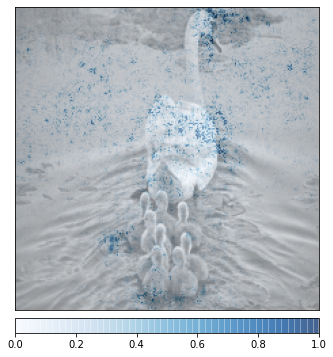

In [161]:
url = "https://github.com/pytorch/captum/raw/master/tutorials/img/resnet/swan-3299528_1280.jpg"
cls = "goose"
get_attr(url, model, transforms)

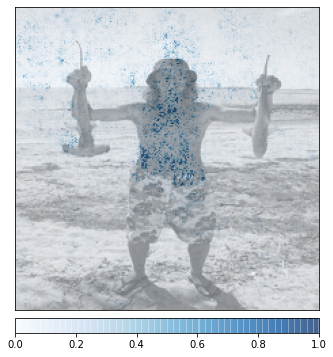

In [162]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01494475_hammerhead.JPEG"
cls = "hammerhead"
get_attr(url, model, transforms)

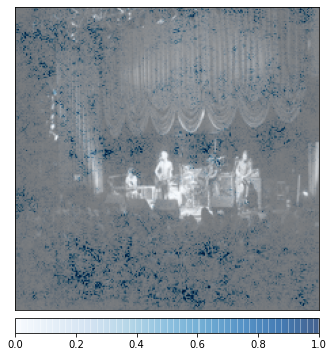

In [165]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04418357_theater_curtain.JPEG"
cls = "theater_curtain"
get_attr(url, model, transforms)